# Overview

Let's replace `tanh` layer to the `Batch Norm` layer. The `tanh` version notebook see [Implement Neural net with tanh layer](https://www.kaggle.com/code/aisuko/implement-neural-net-with-tanh-layer).

We want to use batch normalization, it is the first modern innovations that we're looking into that helped stabilize very deep neural networks and their training.

In [1]:
import random
import torch

# read in all the words
with open('/kaggle/input/character-lm-without-framework/names.txt', 'r', encoding='utf-8') as f:
    words=f.read()

words=words.splitlines()

# build the vocabulary of characters and 
chars=sorted(list(set(''.join(words))))

stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
block_size=3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X,Y=[],[]
    
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix] # crop and append
            
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

random.seed(42)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr, Ytr=build_dataset(words[:n1])     # 80%
Xdev, Ydev=build_dataset(words[n1:n2]) # 10%
Xte, Yte=build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [2]:
import torch

class Linear:
    """
    linear layer
    https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
    """
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight=torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # unit gaussian
        self.bias=torch.zeros(fan_out) if bias else None # default bias initialize to zeros
    
    def __call__(self,x):
        self.out=x@self.weight
        if self.bias is not None:
            self.out+=self.bias
        return self.out
    
    def parameters(self):
        """
        return tensors that are parameters of this layer
        """
        return [self.weight]+([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    """
    batchnorm layer
    https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html formula
    """
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps=eps # used in division
        self.momentum=momentum # keep trakcing running stats
        self.training=True
        # parameters (trained with backprop)
        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean=torch.zeros(dim)
        self.runing_var=torch.ones(dim)
    def __call__(self,x):
        """
        Follow https://arxiv.org/pdf/1502.03167
        
        Algorithm 1
        * mini-batch mean
        * mini-batch variance
        * normalize
        * scale and shift
        """
        # calculate the forward pass
        if self.training:
            xmean=x.mean(0, keepdim=True) # batch mean
            xvar=x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean=self.running_mean
            xvar=self.runing_var
        xhat=(x-xmean)/torch.sqrt(xvar+self.eps) # normalize to unit variance
        self.out =self.gamma*xhat+self.beta # create out attribute for visualization training process
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
                self.running_var=(1-self.momentum)*self.runing_var+self.momentum*xvar
        return self.out
        
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out
    
    def parameters(self):
        """
        No parameters in this layer
        """
        return []

        
        
n_embd=10 # the dimensionality of the character embedding vectors

n_hidden=100 # the number of neurons in the hidden layer of the MLP
g=torch.Generator().manual_seed(2147483647) # for reproducibility

C=torch.randn((vocab_size, n_embd), generator=g)

# sequential 6 MLP layers
layers=[
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden),          Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden),          Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden),          Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden),          Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
#     layers[-1].weight *=0.1

# the latest layer is batch norm and we would not be changing thr weight 
# to make the softmax less confident.
    layers[-1].gamma *=0.1
# we would like to changing the gamma(from the batch norm paper algorithm1), 
# because gamma remember in the bathroom is the variable that multiplicatively interacts
# with the output of taht normalization

    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight*=5/3 # bootser the linear layer by the gain
            
# [C] the embedding matrix
# and all the parameters of all the layers
parameters=[C]+[p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad=True

47024


# Optimization loop

In [3]:
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures


# same optimization as last time
max_steps=200000
batch_size=32
lossi=[]
ud=[] # keep tracking the update ratio

for i in range(max_steps):
    # minibatch construct
    ix=torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb=Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb=C[Xb] # embed the characters into vectors
    x=emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x=layer(x)
    loss=F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad=None
    loss.backward()
    
    # update
    lr=0.1 if i<100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data+=-lr*p.grad
    
    # track stats
    if i%10000==0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        # update=learning rate*gradient
        # we take the standard deviation of the udpate
        # we divide it by the actual content the data of that parameter
        # log10.item() will pop out the float
        # we keep tracking all the parameters and add them to ud
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i>=1000:
        break

      0/ 200000: 3.2870


# Your neural net is saturated


Below is the result of only `tanh` layer version, you can the the sarutated of our net is higher than the net that we used `batch normalization`.
```
layer 1 (      Tanh): mean+0.01, std 0.75, saturated: 18.91%
layer 3 (      Tanh): mean-0.00, std 0.72, saturated: 12.88%
layer 5 (      Tanh): mean+0.02, std 0.71, saturated: 11.19%
layer 7 (      Tanh): mean+0.04, std 0.72, saturated: 11.06%
layer 9 (      Tanh): mean-0.02, std 0.72, saturated: 11.62%
```

After we use batch normalization, we normalize the the layer's output.

layer 2 (      Tanh): mean-0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean+0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean-0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean+0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean-0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

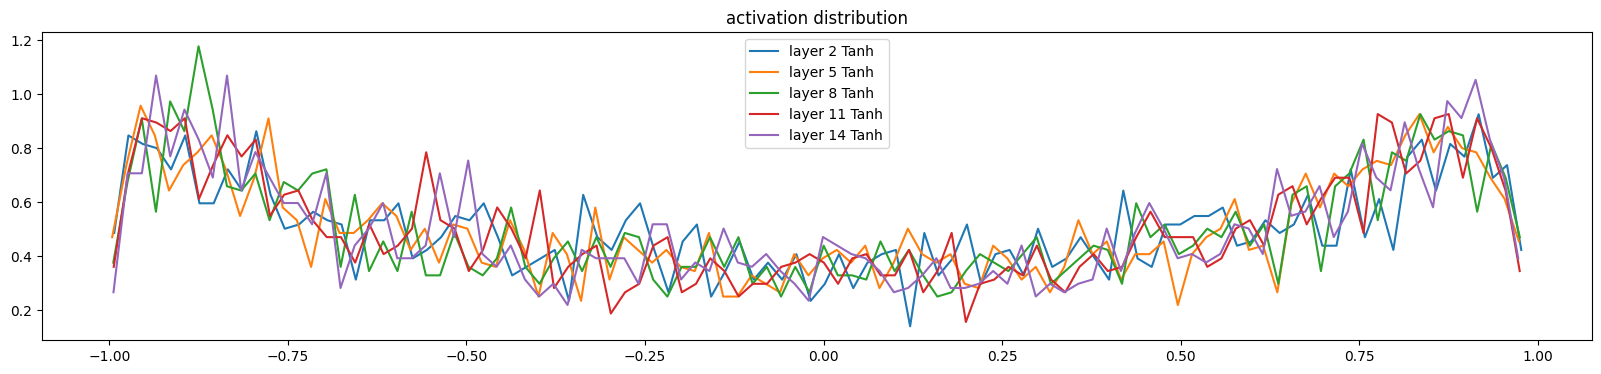

In [4]:
# only for tanh layer
plt.figure(figsize=(20,4)) # width and height of the plot
legends=[]
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer: softmax layer 
    if isinstance(layer, Tanh): # it's finite range and easy to visualize
        t=layer.out
        # only ptint (t.abs()>0.97) the tail of tanh
        print('layer %d (%10s): mean%+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy,hx=torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682959e-03
layer 5 (      Tanh): mean +0.000000, std 3.262612e-03
layer 8 (      Tanh): mean -0.000000, std 2.973733e-03
layer 11 (      Tanh): mean +0.000000, std 2.741114e-03
layer 14 (      Tanh): mean +0.000000, std 2.584294e-03


Text(0.5, 1.0, 'gradient distribution')

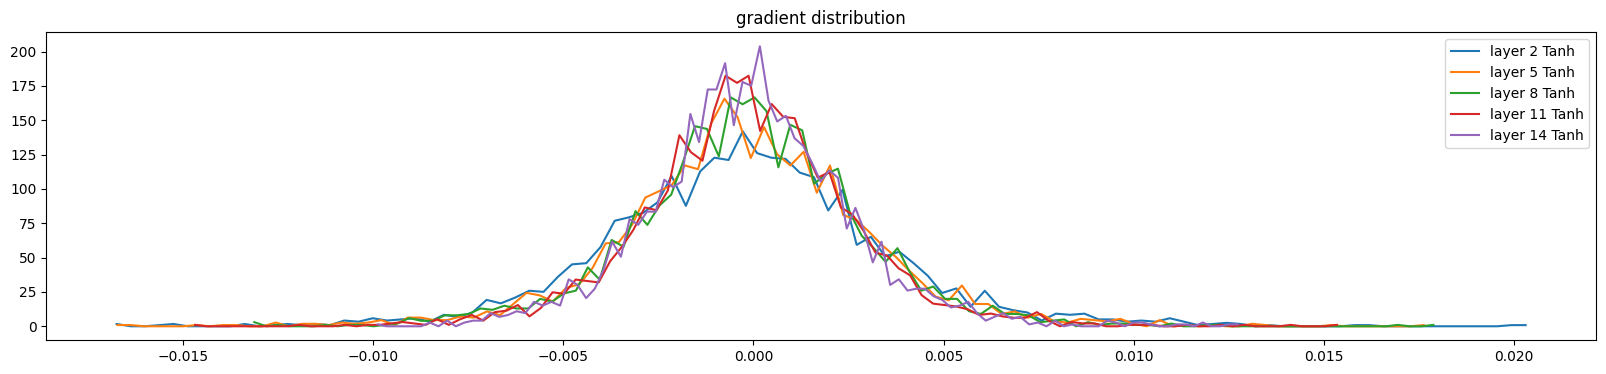

In [5]:
# gradient distribution
plt.figure(figsize=(20,4))
legends=[]
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t=layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx=torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.019889e-02|grad:data rario 1.018849e-02
weight  (30, 100) | mean +0.000092 | std 8.238440e-03|grad:data rario 2.635842e-02
weight (100, 100) | mean +0.000031 | std 7.318122e-03|grad:data rario 4.377151e-02
weight (100, 100) | mean -0.000019 | std 6.662030e-03|grad:data rario 3.949900e-02
weight (100, 100) | mean -0.000019 | std 5.821521e-03|grad:data rario 3.468164e-02
weight (100, 100) | mean +0.000053 | std 5.445301e-03|grad:data rario 3.243370e-02
weight  (100, 27) | mean -0.000165 | std 1.046845e-02|grad:data rario 6.281269e-02


Text(0.5, 1.0, 'weights gradient distribution')

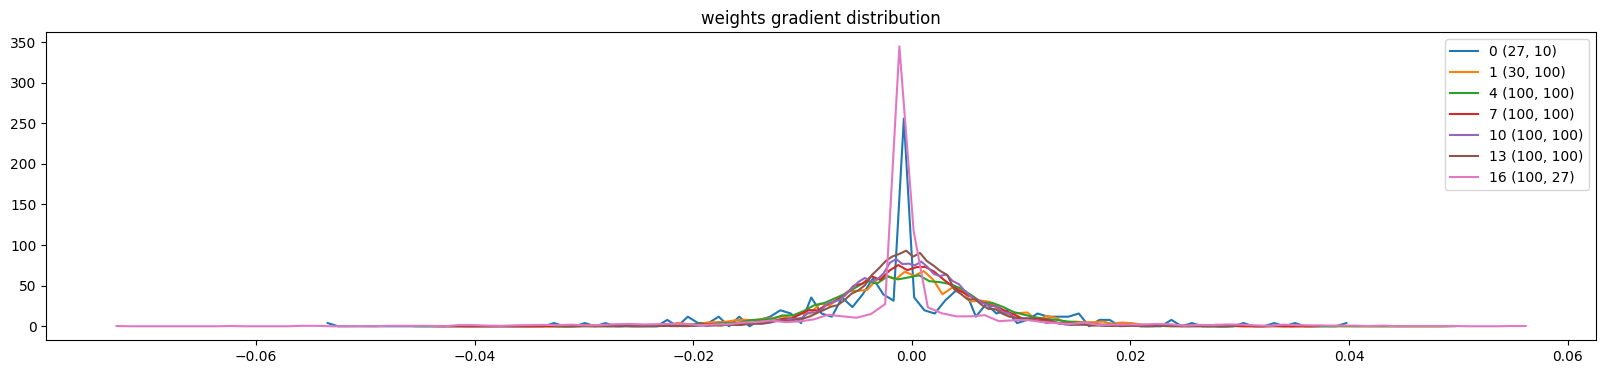

In [6]:
plt.figure(figsize=(20,4))
legends=[]
for i,p in enumerate(parameters):
    t=p.grad
    if p.ndim==2: # restricting to the two dimensional 
        print('weight %10s | mean %+f | std %e|grad:data rario %e' %(tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx=torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')


# it shows what's the scale of gradient compared to the scale of the actual values.

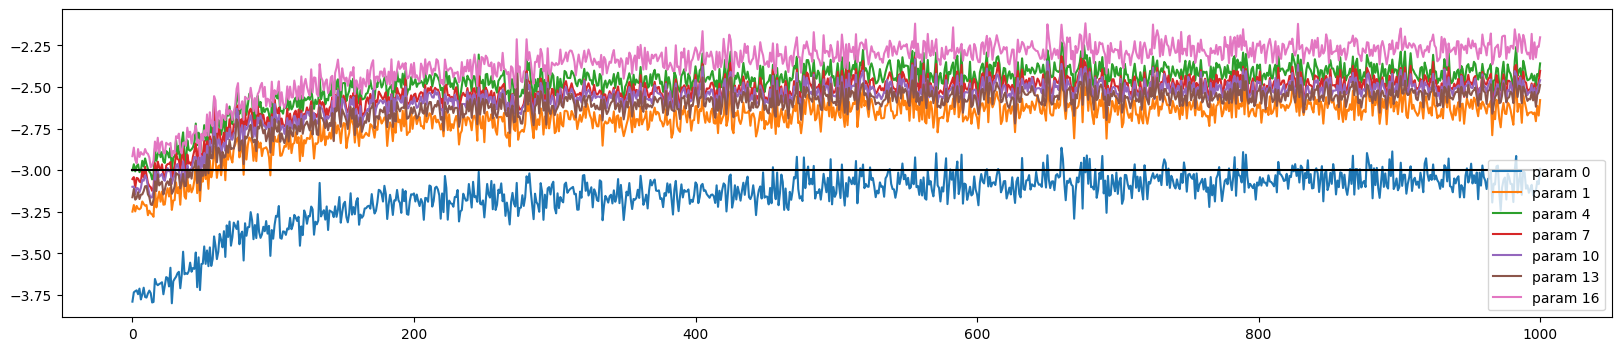

In [7]:
plt.figure(figsize=(20,4))
legends=[]
for i,p in enumerate(parameters):
    if p.ndim==2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0,len(ud)], [-3,-3],'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [8]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y={
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb=C[x] # (N, block_size, n_embd)
    x=emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x=layer(x)
    loss=F.cross_entropy(x,y)
    print(split, loss.item())
    
# put layers into eval mode
for layer in layers:
    layer.training=False
split_loss('train')
split_loss('val')

train 3.1828815937042236
val 3.170095920562744


In [9]:
# sample from the model
g=torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out=[]
    context=[0]*block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb=C[torch.tensor([context])] # (1, block_size, n_embd)
        x=emb.view(emb.shape[0],-1) # concatenate the vectors
        for layer in layers:
            x=layer(x)
        logits=x
        probs=F.softmax(logits, dim=1)
        # sample from the distribution
        ix=torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mria.
kmyan.
kee.
madh.
yal.
reth.
sarje.
leg.
ade.
kare.
ilin.
pare.
jaken.
kan.
xar.
katzi.
son.
ami.
shdh.
rgdh.


# Acknowledgements

* https://www.youtube.com/watch?v=P6sfmUTpUmc&t=5215s
* https://arxiv.org/abs/1502.03167
* https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
* https://arxiv.org/abs/2105.07576
* https://www.kaggle.com/code/aisuko/character-lm-without-framework